
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [7]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.69        31
           1       0.22      0.13      0.17        15
           2       0.35      0.38      0.36        16
           3       0.00      0.00      0.00         7

    accuracy                           0.48        69
   macro avg       0.30      0.33      0.31        69
weighted avg       0.40      0.48      0.43        69

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67        31
           1       0.00      0.00      0.00        15
           2       0.36      0.75      0.49        16
           3       0.00      0.00      0.00         7

    accuracy                           0.48        69
   macro avg       0.25      0.36      0.29        69
weighted avg       0.38      0.48      0.41        69



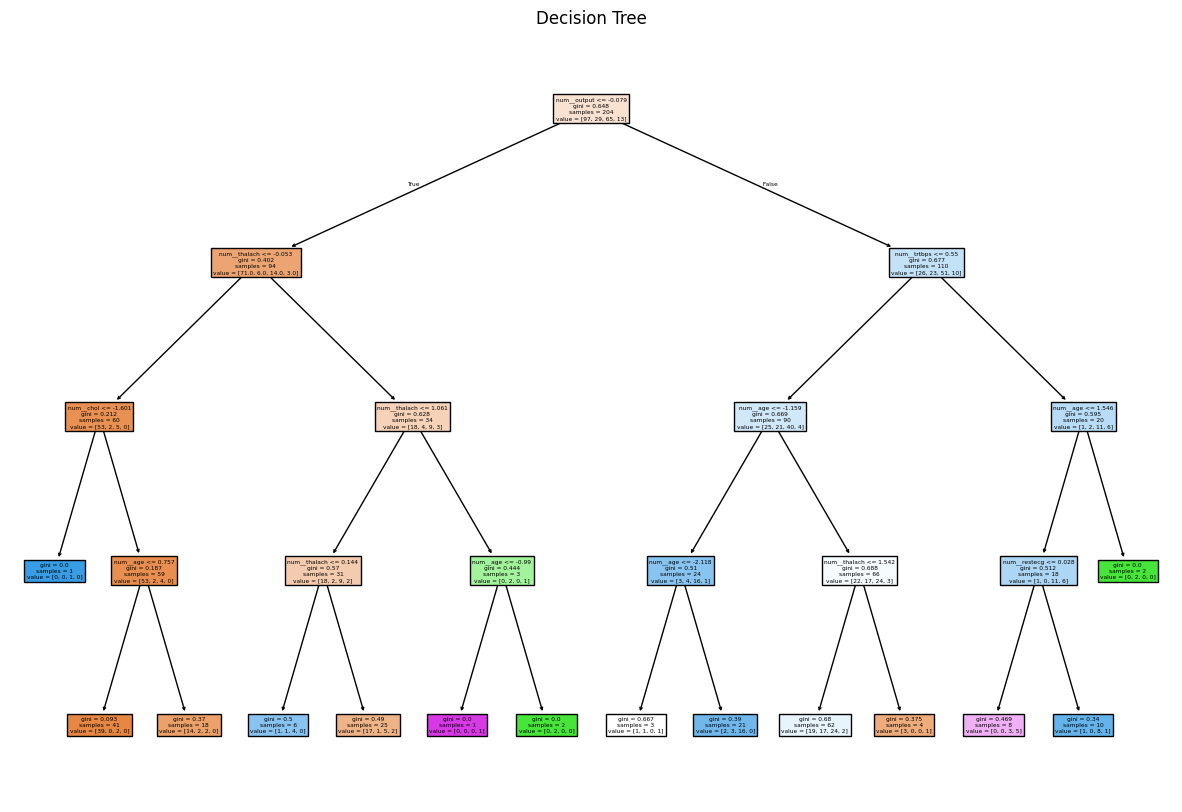

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        31
           1       0.00      0.00      0.00        15
           2       0.34      0.75      0.47        16
           3       0.00      0.00      0.00         7

    accuracy                           0.51        69
   macro avg       0.26      0.37      0.30        69
weighted avg       0.39      0.51      0.43        69



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
X = ha.drop(["cp"], axis=1)
y = ha['cp']

ha = ha.dropna()
X = X.fillna('missing')
y = y.fillna('missing')
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#KNN Pipeline
knn_pipeline = Pipeline([
    ('preprocessor', ct),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

#Decision Tree Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', ct),
    ('dt', DecisionTreeClassifier(max_depth=4))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

decision_tree = dt_pipeline.named_steps ['dt']
plt.figure(figsize=(15, 10))
plot_tree(decision_tree, filled=True, feature_names=ct.get_feature_names_out())#Chatgpt assisted with this
plt.title("Decision Tree")
plt.show()

#LDA Pipeline
lda_pipeline = Pipeline([
    ('preprocessor', ct),
    ('lda', LinearDiscriminantAnalysis())
])

lda_pipeline.fit(X_train, y_train)
y_pred_lda = lda_pipeline.predict(X_test)
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

ha['cp_is_3'] = (ha['cp'] == 3).astype(int)

X = ha.drop(['cp', 'cp_is_3'], axis=1)
y = ha['cp_is_3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

ovr_pipeline = Pipeline([
    ('preprocessor', ct),
    ('logreg', LogisticRegression(solver='liblinear'))
])

ovr_pipeline.fit(X_train, y_train)
y_pred = ovr_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred)

f1_scores = {}
for cp_category in range(1):
    ha[f'cp_is_{cp_category}'] = (ha['cp'] == cp_category).astype(int)
    y = ha[f'cp_is_{cp_category}']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    ovr_pipeline.fit(X_train, y_train)
    y_pred = ovr_pipeline.predict(X_test)
    f1_scores[f'cp_is_{cp_category}'] = f1_score(y_test, y_pred)
for category, score in f1_scores.items():
    print(f"{category}: {score:.4f}") #Chatgpt helped with this part


cp_is_0: 0.7342


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [28]:
from sklearn.metrics import roc_auc_score

ha_01 = ha[ha['cp'].isin([0, 1])]

X = ha_01.drop(['cp'], axis=1)
y = ha_01['cp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

ovo_pipeline = Pipeline([
    ('preprocessor', ct),
    ('logreg', LogisticRegression(solver='liblinear'))
])

ovo_pipeline.fit(X_train, y_train)
y_pred_prob = ovo_pipeline.predict_proba(X_test)[:, 1]

roc_auc_01 = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC cp 0 and cp 1: {roc_auc_01:.4f}")

ha_23 = ha[ha['cp'].isin([2, 3])]

X = ha_23.drop(['cp'], axis=1)
y = ha_23['cp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

ovo_pipeline.fit(X_train, y_train)
y_pred_prob = ovo_pipeline.predict_proba(X_test)[:, 1]

roc_auc_23 = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC cp 2 and cp 3: {roc_auc_23:.4f}")


ROC-AUC cp 0 and cp 1: 0.7244
ROC-AUC cp 2 and cp 3: 0.6013
